## Benchmark models

Let's compare imputation performance.

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

import scp.plots as pl
from scp.benchmark_models import *
import scp.benchmark_models as bm
import scp.simulations as sm
import scp.metrics as metrics
import scp.utils as utils

np.random.seed(0)

## Mask-and-impute experiments

In [2]:
mnar_proportions = [0, 0.25, 0.5, 0.75, 1]

seed = 42

### KNN

In [3]:
def run_imputation_method2(adata, method_fn_name, mnar_proportion, seed, model_name=None, **fn_kwargs):
    m_mnar, m_mcar = sm.create_mnar_mcar_mask(mv_rate=0.08, mnar_proportion=mnar_proportion, x=adata.layers["raw"], seed=seed, sd_scale=5)
    print(f"MNAR: {np.sum(m_mnar) / m_mnar.size:.3f}, MCAR: {np.sum(m_mcar) / m_mcar.size:.3f}")

    train_mask = ~(m_mcar | m_mnar)
    sm.add_train_test_set(adata, train_mask, layer="raw")

    fn = globals()[method_fn_name]
    adata.X = fn(adata, layer="train", **fn_kwargs)

    x_train = adata.layers["train"]
    x_test = adata.layers["test"]

    threshold = 0.10
    mask = np.sum(~np.isnan(x_train), axis=0) / x_train.shape[1] > threshold
    print(f"Columns with at least {threshold * 100}% non-missing values: {100 * np.sum(mask) / mask.size:.2f}")

    m_test = ~np.isnan(x_test)
    m = np.any(m_test, axis=0).reshape(1, -1).repeat(m_test.shape[0], axis=0)

    x_guess = adata.X.copy()[m]
    x_true = x_test[m]

    ok = ~np.isnan(x_guess) & ~np.isnan(x_true)
    x_guess = x_guess[ok]
    x_true = x_true[ok]  

    mse_test = metrics.mse(x_guess, x_true)

    print(f"Test MSE (individual): {mse_test:.4f}")

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    v_min = np.min([np.nanmin(x_true), np.nanmin(x_guess)])
    v_max = np.max([np.nanmax(x_true), np.nanmax(x_guess)])

    ax.plot([v_min, v_max], [v_min, v_max], ls="--", c="black")
    ax.scatter(x_true, x_guess, s=1, alpha=0.1)
    ax.set_xlabel("True expression")
    ax.set_ylabel("Imputed expression")
    ax.set_title(f"Imputation accuracy (MSE: {mse_test:.4f})")
    ax.grid(True)
    fig.show()

    x_guess_means = np.nanmean(x_guess, axis=0)
    x_true_means = np.nanmean(x_true, axis=0)

    mse_test_agg = np.nanmean(x_guess_means - x_true_means)**2

    print(f"Test MSE (aggregate): {mse_test_agg:.4f}")

    model = method_fn_name if model_name is None else model_name

    res = {
        "model": model,
        "mnar_proportion": mnar_proportion,
        "mse_test": mse_test,
        "mse_test_agg": mse_test_agg
    }

    PATH = "../../../results/brunner2022/mai"
    path = os.path.join(PATH, f"{model}_{mnar_proportion}.pkl")
    utils.save_dict(res, path)

In [4]:
adata = sc.read_h5ad("../../../data/processed/brunner2022.h5ad")

MNAR: 0.000, MCAR: 0.080
Columns with at least 10.0% non-missing values: 40.22
Test MSE (individual): 0.0813
Test MSE (aggregate): 0.0000
MNAR: 0.014, MCAR: 0.061
Columns with at least 10.0% non-missing values: 39.90
Test MSE (individual): 0.0959
Test MSE (aggregate): 0.0006
MNAR: 0.021, MCAR: 0.042
Columns with at least 10.0% non-missing values: 39.94
Test MSE (individual): 0.1041
Test MSE (aggregate): 0.0014
MNAR: 0.031, MCAR: 0.021
Columns with at least 10.0% non-missing values: 39.66
Test MSE (individual): 0.1116
Test MSE (aggregate): 0.0026
MNAR: 0.041, MCAR: 0.000
Columns with at least 10.0% non-missing values: 39.38
Test MSE (individual): 0.1186
Test MSE (aggregate): 0.0043


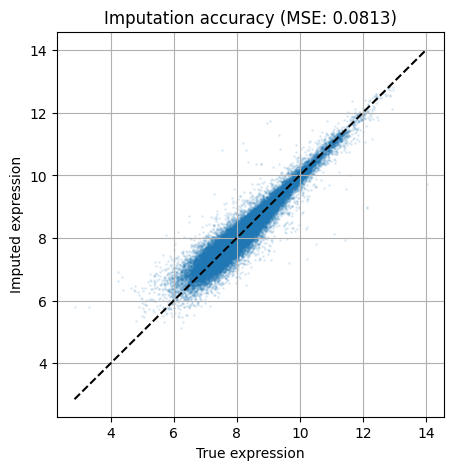

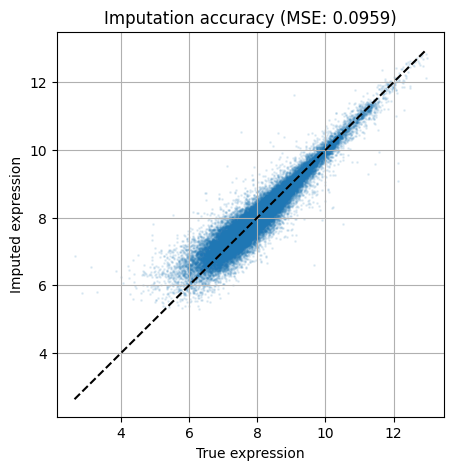

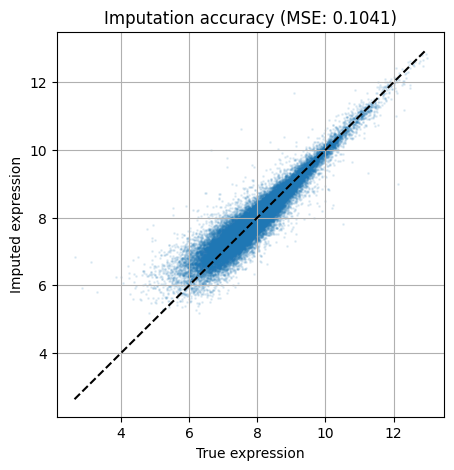

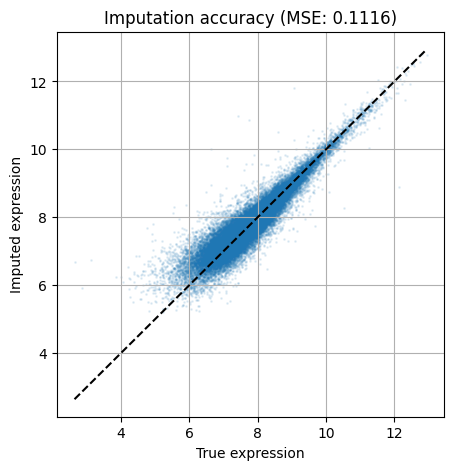

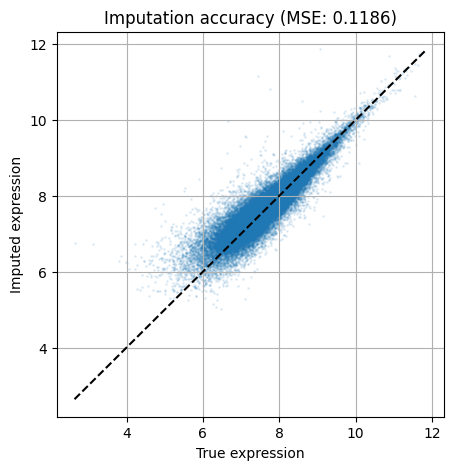

In [5]:
for mnar_proportion in mnar_proportions:
    run_imputation_method2(adata, "impute_knn", mnar_proportion=mnar_proportion, seed=seed, model_name="5-nn")

MNAR: 0.000, MCAR: 0.080
Test MSE (individual): 0.4759
Test MSE (aggregate): 0.3123
MNAR: 0.014, MCAR: 0.061
Test MSE (individual): 0.4596
Test MSE (aggregate): 0.2913
MNAR: 0.021, MCAR: 0.042
Test MSE (individual): 0.4561
Test MSE (aggregate): 0.2824
MNAR: 0.031, MCAR: 0.021
Test MSE (individual): 0.4474
Test MSE (aggregate): 0.2700
MNAR: 0.041, MCAR: 0.000
Test MSE (individual): 0.4339
Test MSE (aggregate): 0.2581


/home/rasmus/sollertis/school/s11/thesis/MS_mv_modelling/scp/benchmark_models.py:74: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(x, axis=0)
/home/rasmus/anaconda3/envs/scp/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


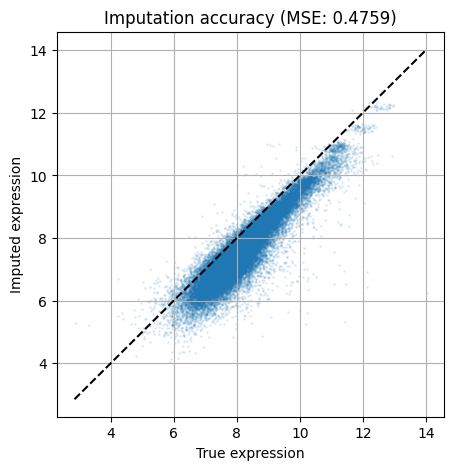

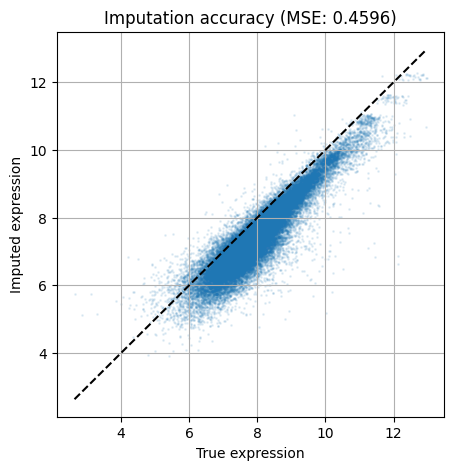

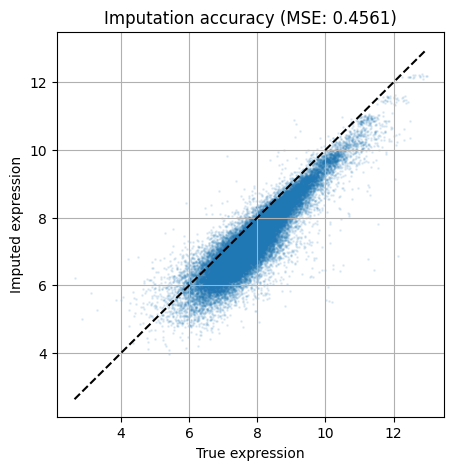

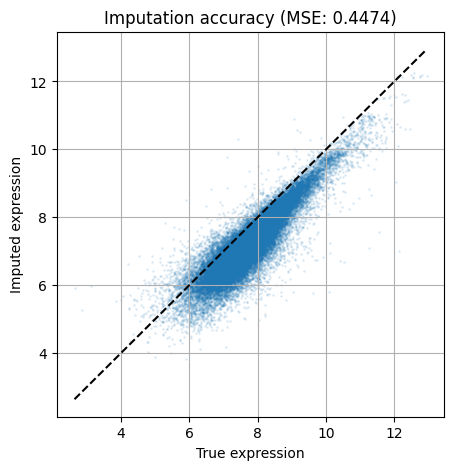

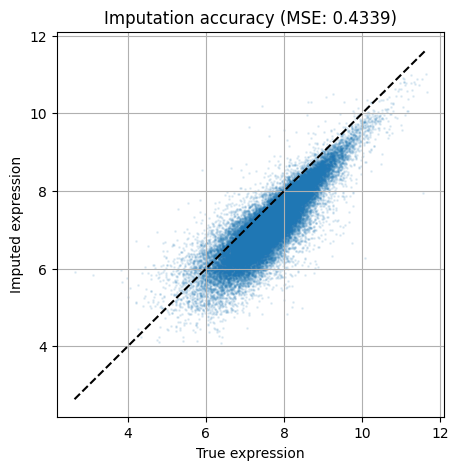

In [ ]:
for mnar_proportion in mnar_proportions:
    run_imputation_method2(adata, "impute_downshifted_normal_local", mnar_proportion=mnar_proportion, model_name="downshift local", seed=seed)

In [ ]:
adata = sc.read_h5ad("../../../data/processed/brunner2022.h5ad")

In [ ]:
from scp.benchmark_models import run_protDP

In [ ]:
for mnar_proportion in mnar_proportions:
    m_mnar, m_mcar = sm.create_mnar_mcar_mask(mv_rate=0.08, mnar_proportion=mnar_proportion, x=adata.layers["raw"], seed=seed)
    print(f"MNAR: {np.sum(m_mnar) / m_mnar.size:.3f}, MCAR: {np.sum(m_mcar) / m_mcar.size:.3f}")

    train_mask = ~(m_mcar | m_mnar)
    sm.add_train_test_set(adata, train_mask, layer="raw")

    result = run_protDP(adata, layer="raw")

    x_test = adata.layers["test"]
    x_true = x_test[~np.isnan(x_test)]
    x_true_means = np.nanmean(x_true, axis=0)

    x_guess_means = result["mu_mis"]

    mse_test_agg = np.nanmean(x_guess_means - x_true_means)**2

    print(f"Test MSE (aggregate): {mse_test_agg:.4f}")

    model = "protDP"

    res = {
        "model": model,
        "mnar_proportion": mnar_proportion,
        "mse_test_agg": mse_test_agg
    }

    PATH = "../../../results/brunner2022/mai"
    path = os.path.join(PATH, f"{model}_{mnar_proportion}.pkl")
    utils.save_dict(res, path)

MNAR: 0.000, MCAR: 0.080
Test MSE (aggregate): 0.3795
MNAR: 0.010, MCAR: 0.061
Test MSE (aggregate): 0.0323
MNAR: 0.021, MCAR: 0.042
Test MSE (aggregate): 0.0290
MNAR: 0.031, MCAR: 0.021
Test MSE (aggregate): 0.2437
MNAR: 0.041, MCAR: 0.000
Test MSE (aggregate): 0.6423
